### Set Up

In [1]:
# if you're running this cell in Kaggle Notebook, don't forget to turn on the internet of your notebook
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from torch_geometric.data import Data, DataLoader

# Input Data

In [3]:
# Load the datasets
hr_df = pd.read_csv("/notebooks/hr_train.csv") 
lr_df = pd.read_csv("/notebooks/lr_train.csv")

# Convert to numpy arrays
hr_data = hr_df.values
lr_data = lr_df.values

# Data Preprocessing

### Data Distribution Visualization

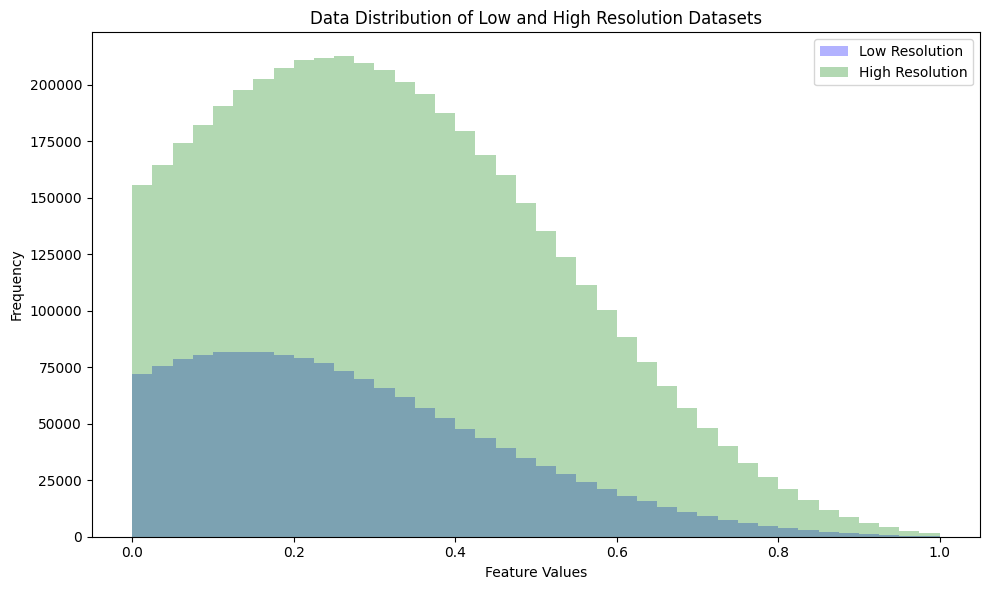

In [3]:
# Overlayed histograms for both datasets
plt.figure(figsize=(10, 6))

# Flatten the data to 1D for histogram plotting of non zero values
lr_flat = np.ravel(lr_data[lr_data != 0])
hr_flat = np.ravel(hr_data[hr_data != 0])

# Calculate the number of bins for the histogram
bins = np.histogram(np.hstack((lr_flat, hr_flat)), bins=40)[1] # get the bin edges

plt.hist(lr_flat, bins=bins, color='blue', alpha=0.3, label='Low Resolution', density=False)
plt.hist(hr_flat, bins=bins, color='green', alpha=0.3, label='High Resolution', density=False)

plt.title('Data Distribution of Low and High Resolution Datasets')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Vectorization & Antivectorization

In [4]:
class MatrixVectorizer:
    """
    A class for transforming between matrices and vector representations.
    
    This class provides methods to convert a symmetric matrix into a vector (vectorize)
    and to reconstruct the matrix from its vector form (anti_vectorize), focusing on 
    vertical (column-based) traversal and handling of elements.
    """

    def __init__(self):
        """
        Initializes the MatrixVectorizer instance.
        
        The constructor currently does not perform any actions but is included for 
        potential future extensions where initialization parameters might be required.
        """
        pass

    @staticmethod
    def vectorize(matrix, include_diagonal=False):
        """
        Converts a matrix into a vector by vertically extracting elements.
        
        This method traverses the matrix column by column, collecting elements from the
        upper triangle, and optionally includes the diagonal elements immediately below
        the main diagonal based on the include_diagonal flag.
        
        Parameters:
        - matrix (numpy.ndarray): The matrix to be vectorized.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the vectorization.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The vectorized form of the matrix.
        """
        # Determine the size of the matrix based on its first dimension
        matrix_size = matrix.shape[0]

        # Initialize an empty list to accumulate vector elements
        vector_elements = []

        # Iterate over columns and then rows to collect the relevant elements
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Collect upper triangle elements
                        vector_elements.append(matrix[row, col])
                    elif include_diagonal and row == col + 1:
                        # Optionally include the diagonal elements immediately below the diagonal
                        vector_elements.append(matrix[row, col])

        return np.array(vector_elements)

    @staticmethod
    def anti_vectorize(vector, matrix_size, include_diagonal=False):
        """
        Reconstructs a matrix from its vector form, filling it vertically.
        
        The method fills the matrix by reflecting vector elements into the upper triangle
        and optionally including the diagonal elements based on the include_diagonal flag.
        
        Parameters:
        - vector (numpy.ndarray): The vector to be transformed into a matrix.
        - matrix_size (int): The size of the square matrix to be reconstructed.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the reconstruction.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The reconstructed square matrix.
        """
        # Initialize a square matrix of zeros with the specified size
        matrix = np.zeros((matrix_size, matrix_size))

        # Index to keep track of the current position in the vector
        vector_idx = 0

        # Fill the matrix by iterating over columns and then rows
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Reflect vector elements into the upper triangle and its mirror in the lower triangle
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1
                    elif include_diagonal and row == col + 1:
                        # Optionally fill the diagonal elements after completing each column
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1

        return matrix

In [5]:
def load_dataset_as_graphs(df, matrix_size):
    graphs = []
    for index, row in df.iterrows():
        vector = row.values
        graph = load_vector_as_graph(vector, matrix_size)
        graphs.append(graph)
    return graphs


def load_vector_as_graph(vector, matrix_size):
    adjacency_matrix = MatrixVectorizer.anti_vectorize(vector, matrix_size)

    x = torch.tensor(adjacency_matrix, dtype=torch.float)
    edge_attr = x.view(-1, 1)
    
    edge_index = []
    for i in range(matrix_size):
        for j in range(matrix_size):
            edge_index.append([i, j])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return graph


def load_matrix_as_graph(matrix):
    adjacency_matrix = matrix

    x = torch.tensor(adjacency_matrix, dtype=torch.float)
    edge_attr = x.view(-1, 1)
    
    edge_index = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            edge_index.append([i, j])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return graph


def get_matrix_size(num_features):
    return int(np.sqrt(num_features * 2)) + 1

### Split Data for Training, Testing, and Validation

In [6]:
# Determine the matrix size for low-resolution and high-resolution data
lr_matrix_size = get_matrix_size(lr_df.shape[1])
hr_matrix_size = get_matrix_size(hr_df.shape[1])

# Convert the dataframe to graph objects
lr_graphs = load_dataset_as_graphs(lr_df, lr_matrix_size)
hr_graphs = load_dataset_as_graphs(hr_df, hr_matrix_size)

# Split the data into training and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(
    lr_graphs, hr_graphs, test_size=0.2, random_state=42
)

In [7]:
print("LR Train Set samples: ",len(lr_train))
print("LR Test Set samples: ",len(lr_test))

print("HR Train Set samples: ",len(hr_train))
print("HR Test Set samples: ",len(lr_test))

LR Train Set samples:  133
LR Test Set samples:  34
HR Train Set samples:  133
HR Test Set samples:  34


# Model

### Model Setup

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, Upsample
from torch_geometric.nn import NNConv, GCNConv, BatchNorm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch.autograd import Variable

In [9]:
# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

torch.cuda.empty_cache()

CUDA is available. Using GPU.


In [10]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current CUDA device
    device = torch.cuda.current_device()

    # Get the memory allocated and cached
    allocated_memory = torch.cuda.memory_allocated(device) / 1024**3  # Convert bytes to GB
    cached_memory = torch.cuda.memory_reserved(device) / 1024**3  # Convert bytes to GB

    print(f"Allocated GPU memory: {allocated_memory:.2f} GB")
    print(f"Cached GPU memory: {cached_memory:.2f} GB")
else:
    print("CUDA is not available.")

Allocated GPU memory: 0.00 GB
Cached GPU memory: 0.00 GB


In [11]:
N_SUBJECTS = len(lr_train)
N_SOURCE_NODES = lr_train[0].num_nodes
N_TARGET_NODES = hr_train[0].num_nodes
N_EPOCHS = 100
BATCH_SIZE = 1

N_SOURCE_NODES_F =int((N_SOURCE_NODES*(N_SOURCE_NODES-1))/2)
N_TARGET_NODES_F =int((N_TARGET_NODES*(N_TARGET_NODES-1))/2)

### Model Definition

In [12]:
class Aligner(torch.nn.Module):
    def __init__(self):
        
        super(Aligner, self).__init__()

        nn = Sequential(Linear(1, N_SOURCE_NODES*N_SOURCE_NODES), ReLU())
        self.conv1 = NNConv(N_SOURCE_NODES, N_SOURCE_NODES, nn, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(N_SOURCE_NODES, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        nn = Sequential(Linear(1, N_SOURCE_NODES), ReLU())
        self.conv2 = NNConv(N_SOURCE_NODES, 1, nn, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        nn = Sequential(Linear(1, N_SOURCE_NODES), ReLU())
        self.conv3 = NNConv(1, N_SOURCE_NODES, nn, aggr='mean', root_weight=True, bias=True)
        self.conv33 = BatchNorm(N_SOURCE_NODES, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = F.sigmoid(self.conv11(self.conv1(x, edge_index, edge_attr)))
        x1 = F.dropout(x1, training=self.training)

        x2 = F.sigmoid(self.conv22(self.conv2(x1, edge_index, edge_attr)))
        x2 = F.dropout(x2, training=self.training)

        x3 = torch.cat([F.sigmoid(self.conv33(self.conv3(x2, edge_index, edge_attr))), x1], dim=1)
        x4 = x3[:, 0:N_SOURCE_NODES]
        x5 = x3[:, N_SOURCE_NODES:2*N_SOURCE_NODES]

        x6 = (x4 + x5) / 2
        return x6
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        nn = Sequential(Linear(1, N_SOURCE_NODES*N_SOURCE_NODES),ReLU())
        self.conv1 = NNConv(N_SOURCE_NODES, N_SOURCE_NODES, nn, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(N_SOURCE_NODES, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        nn = Sequential(Linear(1, N_TARGET_NODES*N_SOURCE_NODES), ReLU())
        self.conv2 = NNConv(N_TARGET_NODES, N_SOURCE_NODES, nn, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(N_SOURCE_NODES, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        nn = Sequential(Linear(1, N_TARGET_NODES*N_SOURCE_NODES), ReLU())
        self.conv3 = NNConv(N_SOURCE_NODES, N_TARGET_NODES, nn, aggr='mean', root_weight=True, bias=True)
        self.conv33 = BatchNorm(N_TARGET_NODES, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = F.sigmoid(self.conv11(self.conv1(x, edge_index, edge_attr)))
        x1 = F.dropout(x1, training=self.training)

        x3 = F.sigmoid(self.conv33(self.conv3(x1, edge_index, edge_attr)))
        x3 = F.dropout(x3, training=self.training)

        x4  = torch.matmul(x3.t(), x3)
        return x4

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = GCNConv(N_TARGET_NODES, N_TARGET_NODES, cached=True)
        self.conv2 = GCNConv(N_TARGET_NODES, 1, cached=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = torch.squeeze(x)
        x1 = F.sigmoid(self.conv1(x, edge_index))
        x1 = F.dropout(x1, training=self.training)
        x2 = F.sigmoid(self.conv2(x1, edge_index))
        return x2

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize your models
aligner = Aligner()
generator = Generator()
discriminator = Discriminator()

# Count the parameters
aligner_params = count_parameters(aligner)
generator_params = count_parameters(generator)
discriminator_params = count_parameters(discriminator)

print(f"Aligner Parameters: {aligner_params}")
print(f"Generator Parameters: {generator_params}")
print(f"Discriminator Parameters: {discriminator_params}")
print(f"Total Parameters: {aligner_params+generator_params+discriminator_params}")

### Loss Function Definition

In [13]:
import numpy as np
import networkx as nx

##### helper functions

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160
    topology_eigen = []
    np.fill_diagonal(data, 0)

    # create a graph from similarity matrix
    G = nx.from_numpy_matrix(np.absolute(data))
    U = G.to_undirected()
    
    # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    eigenvector_centrality = np.array([ec[g] for g in U])
    topology_eigen.append(eigenvector_centrality)  # 2
    return topology_eigen

def pearson_correlation(target, input):
    vx = input - torch.mean(input)
    vy = target - torch.mean(target)
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    return cost

In [14]:
def aligner_loss(target, predicted):
    kl_loss = torch.abs(F.kl_div(F.softmax(target), F.softmax(predicted), None, None, 'sum'))
    kl_loss = (1/350) * kl_loss
    return kl_loss

discriminator_loss = torch.nn.BCELoss()
discriminator_loss.to(device)

def generator_loss(target, predicted):
    l1_loss = torch.nn.L1Loss()
    l1_loss.to(device)

    # l1_loss
    loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    target_t = eigen_centrality(target_n)
    real_topology = torch.tensor(target_t)
    predicted_t = eigen_centrality(predicted_n)
    fake_topology = torch.tensor(predicted_t)
    topo_loss = l1_loss(fake_topology, real_topology)

    pc_loss = pearson_correlation(target, predicted).to(device)
    torch.cuda.empty_cache()

    G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss

    return G_loss


### Training

In [15]:
from torch_geometric.loader import DataLoader as GraphDataLoader
# Load training data
lr_loader = GraphDataLoader(lr_train, batch_size=BATCH_SIZE, shuffle=True)
hr_loader = GraphDataLoader(hr_train, batch_size=BATCH_SIZE, shuffle=True)

# # Initialize models
aligner = Aligner().to(device)
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

In [16]:
def train_graph_gnn(epochs, lr_loader, hr_loader, aligner, device):
    # Loss function
    criterion = torch.nn.BCEWithLogitsLoss()

    # Optimizers
    optimizer_A = torch.optim.AdamW(aligner.parameters(), lr=0.025, betas=(0.5, 0.999))
    # optimizer_G = torch.optim.AdamW(generator.parameters(), lr=0.025, betas=(0.5, 0.999))
    # optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=0.025, betas=(0.5, 0.999))

    aligner.train()
    # generator.train()
    # discriminator.train()
    
    for epoch in range(epochs):
        A_losses = []
        G_losses = []
        for lr_data, hr_data in zip(lr_loader, hr_loader):

            lr_data = lr_data.to(device)
            hr_data = hr_data.to(device)

            # === Train Aligner ===
            A_output = aligner(lr_data)
            # A_output_cast = load_matrix_as_graph(A_output)

            target = hr_data.edge_attr.view(N_TARGET_NODES, N_TARGET_NODES).detach().cpu().clone().numpy()
            target_mean = np.mean(target)
            target_std = np.std(target)

            d_target = torch.normal(target_mean, target_std, size=(1, N_SOURCE_NODES_F))
            d_target_copy = d_target.detach().cpu().clone().numpy()
            dd_target = load_vector_as_graph(np.squeeze(d_target_copy),N_SOURCE_NODES)
            dd_target = dd_target.to(device)
            target_d = dd_target.edge_attr.view(N_SOURCE_NODES, N_SOURCE_NODES)

            A_loss = aligner_loss(target_d, A_output)
            A_losses.append(A_loss)

        optimizer_A.zero_grad()
        A_losses = torch.mean(torch.stack(A_losses))
        A_losses.backward(retain_graph=True)
        optimizer_A.step() 
            
        print("[Epoch: %d]| [Al loss: %f]" % (epochs, A_losses))


In [17]:
train_graph_gnn(N_EPOCHS, lr_loader, hr_loader, aligner, device)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_540/3110986019.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kl_loss = torch.abs(F.kl_div(F.softmax(target), F.softmax(predicted), None, None, 'sum'))


RuntimeError: CUDA out of memory. Tried to allocate 2.44 GiB (GPU 0; 15.89 GiB total capacity; 12.48 GiB already allocated; 680.69 MiB free; 14.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Testing

In [ ]:
test_data = [
    (lr, hr) for lr, hr in zip(lr_test, hr_test)
]
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

# the following numbers do not reflect the provided dataset, just for an example
num_test_samples = 20
num_roi = 10

# create a random model output 
pred_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()

# post-processing
pred_matrices[pred_matrices < 0] = 0

# create random ground-truth data
gt_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()

# you do NOT need to that since the ground-truth data we provided you is alread pre-processed.
gt_matrices[gt_matrices < 0] = 0

# Initialize lists to store MAEs for each centrality measure
mae_bc = []
mae_ec = []
mae_pc = []

pred_1d_list = []
gt_1d_list = []

# Iterate over each test sample
for i in range(num_test_samples):
    # Convert adjacency matrices to NetworkX graphs
    pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
    gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")

    # Compute centrality measures
    pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
    pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
    pred_pc = nx.pagerank(pred_graph, weight="weight")

    gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
    gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
    gt_pc = nx.pagerank(gt_graph, weight="weight")

    # Convert centrality dictionaries to lists
    pred_bc_values = list(pred_bc.values())
    pred_ec_values = list(pred_ec.values())
    pred_pc_values = list(pred_pc.values())

    gt_bc_values = list(gt_bc.values())
    gt_ec_values = list(gt_ec.values())
    gt_pc_values = list(gt_pc.values())

    # Compute MAEs
    mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
    mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
    mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    # Vectorize matrices
    pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
    gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))

# Compute average MAEs
avg_mae_bc = sum(mae_bc) / len(mae_bc)
avg_mae_ec = sum(mae_ec) / len(mae_ec)
avg_mae_pc = sum(mae_pc) / len(mae_pc)

# Concatenate flattened matrices
pred_1d = np.concatenate(pred_1d_list)
gt_1d = np.concatenate(gt_1d_list)

# Compute metrics
mae = mean_absolute_error(pred_1d, gt_1d)
pcc = pearsonr(pred_1d, gt_1d)[0]
js_dis = jensenshannon(pred_1d, gt_1d)

print("MAE: ", mae)
print("PCC: ", pcc)
print("Jensen-Shannon Distance: ", js_dis)
print("Average MAE betweenness centrality:", avg_mae_bc)
print("Average MAE eigenvector centrality:", avg_mae_ec)
print("Average MAE PageRank centrality:", avg_mae_pc)